<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-train-data" data-toc-modified-id="Loading-train-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading train data</a></span><ul class="toc-item"><li><span><a href="#Merging-train-and-test-data" data-toc-modified-id="Merging-train-and-test-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Merging train and test data</a></span></li><li><span><a href="#Merging-user-data" data-toc-modified-id="Merging-user-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Merging user data</a></span></li><li><span><a href="#Competitions-based-features" data-toc-modified-id="Competitions-based-features-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Competitions based features</a></span></li><li><span><a href="#Competitions-data" data-toc-modified-id="Competitions-data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Competitions data</a></span></li><li><span><a href="#Time-based-competitions-features" data-toc-modified-id="Time-based-competitions-features-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Time based competitions features</a></span></li><li><span><a href="#Current-active-competitions-feature" data-toc-modified-id="Current-active-competitions-feature-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Current active competitions feature</a></span></li><li><span><a href="#User-Interests-Feature" data-toc-modified-id="User-Interests-Feature-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>User Interests Feature</a></span></li><li><span><a href="#Submissions-based-features" data-toc-modified-id="Submissions-based-features-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Submissions based features</a></span></li><li><span><a href="#Discussion-based-features" data-toc-modified-id="Discussion-based-features-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Discussion based features</a></span></li><li><span><a href="#Comments-based-features" data-toc-modified-id="Comments-based-features-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Comments based features</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Submission</a></span></li></ul></div>

In [168]:
%load_ext autoreload
%autoreload 2

import ast
import os
import gc
import sys
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GroupKFold
from catboost import CatBoostClassifier
from category_encoders import CountEncoder
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

warnings.filterwarnings("ignore")
pd.set_option("max_colwidth", None)
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
# class Config:
#     LAG = 3
#     VER = f'final_sub_v1'
#     OUTPUT_DIR = '.'
#     DATA_DIR = '.'
#     DEBUG = True
#     N_SPLITS = 5

In [170]:
# LOCAL_TEST_RUN = False
seed = 0
# def seed_everything(seed=0):
random.seed(seed)
np.random.seed(seed)

# seed_everything()

## Loading Train Data

In [171]:
# Create target variable
def target_var(train):
    target = []
    for _, row in train.iterrows():
        if row['CompPart'] == 1:
            target.append('CompPart')
            continue
        elif row['Sub'] == 1 or row['Comment'] == 1 or row['Disc'] == 1:
            target.append('Sub')
            continue
        else:
            target.append('NoActivity')
        
    return target

In [172]:
# Read train data
train = pd.read_csv("./Train.csv", index_col = None)
print(train.shape)

# Create target column from existing train data
train['Target'] = target_var(train)
train.head(5)

(259832, 8)


,User_ID,month,year,CompPart,Comment,Sub,Disc,Target
0,ID_XI7BAR4Y,8,3,0,0,0,0,NoActivity
1,ID_XI7BAR4Y,8,2,0,0,0,0,NoActivity
2,ID_XI7BAR4Y,9,2,0,0,0,0,NoActivity
3,ID_XI7BAR4Y,9,3,0,0,0,0,NoActivity
4,ID_XI7BAR4Y,10,3,0,0,0,0,NoActivity


In [173]:
# Read test data
test = pd.read_csv("./Test.csv", index_col = None)
print(test.shape)

test.head(5)

(65223, 3)


,User_ID,month,year
0,ID_H1ELY25E,1,4
1,ID_H1ELY25E,2,4
2,ID_H1ELY25E,3,4
3,ID_463Q2BCO,1,4
4,ID_463Q2BCO,2,4


In [174]:
# Create time columns in dataset
def define_timestamp(df):
    year_month = df['year'].astype(str) + \
        df['month'].apply(lambda x: str(x).zfill(2))
    df['year_month'] = year_month.astype(int)
    df = df.sort_values(by = 'year_month').reset_index(drop = True)
    df['timestamp'] = np.arange(1, len(df) + 1)
    return df

## Merging train and test data

In [175]:
train['is_train'] = 1
test['is_train'] = 0

data = train.append(test, ignore_index=True)
timestamp = data[['year', 'month']].drop_duplicates()
timestamp = define_timestamp(timestamp)
data = data.merge(timestamp, how = 'left')
all_timestamps = data[['User_ID', 'timestamp', 'year', 'month']].drop_duplicates().reset_index(drop = True)

data = data.sort_values(by='timestamp').reset_index(drop=True)
data['Record'] = 1
data['Total_Num_User_Months'] = data.groupby('User_ID')['Record'].apply(lambda x: x.cumsum())

## Merging user data

In [176]:
users = pd.read_csv("./Users.csv", index_col = None)
users.columns = ['User_ID', 'FeatureX', 'Country', 'FeatureY', 'Points', 'year', 'month', 'dayofweek']
users = users.merge(timestamp, how = 'left')
users = users.rename(columns={"timestamp": "Zindi_Joining_Timestamp"})
users.drop(['dayofweek', 'year', 'month', 'year_month'], axis = 1, inplace = True)
users.head(5)

,User_ID,FeatureX,Country,FeatureY,Points,Zindi_Joining_Timestamp
0,ID_N5LTBAPU,0,ID_DMRM,1,group 3,13
1,ID_CLSFQB0S,0,ID_Q02,3,group 3,2
2,ID_RE6T58Y4,0,ID_Q02,0,group 3,21
3,ID_XJQQRJV3,0,ID_Z8BI,0,group 3,18
4,ID_1JHU6A8S,0,ID_Q02,3,group 3,19


In [177]:
data = data.merge(users, how='left')

columns = ['FeatureX', 'Country', 'FeatureY', 'Points']
data[columns] = data[columns].astype(str)

## Competitions based features

In [178]:
competition_data = pd.read_csv("./CompetitionPartipation.csv", index_col=None)
competition_data.columns = [
    'CompID', 'User_ID', 'PublicRank', 'Successful_Sub_Count',
    'year', 'month', 'dayofweek'
]
    
competition_timestamp = competition_data.merge(timestamp, how='left')
competition_timestamp = competition_timestamp[[
    'User_ID', 'month', 'year', 'timestamp'
]].drop_duplicates()
competition_timestamp.columns = [
    'User_ID', 'month', 'year', 'comp_timestamp'
]
data = data.merge(competition_timestamp, how='left')

data = data.sort_values(by='timestamp').reset_index(drop=True)
data['comp_timestamp'] = data.groupby('User_ID')['comp_timestamp'].apply(lambda x: x.ffill().shift())
data['Months_Since_Last_Comp'] = data['timestamp'] - data['comp_timestamp']
data['Months_Since_Joining_Zindi'] = data['comp_timestamp'] - data['Zindi_Joining_Timestamp']

## Competitions data

In [179]:
competitions = pd.read_csv("./Competitions.csv", index_col=None, skipinitialspace=True)
competitions['CompEndTime Year'] = [
    int(val) if val != 'not mapped' else 999 \
    for val in competitions['CompEndTime Year']
]
competitions['FeatureC'] = competitions['FeatureC'].fillna(-1).astype(np.int8)
competitions = competitions.merge(
    timestamp,
    left_on=['CompStartTime Year', 'CompStartTime Month'],
    right_on=['year', 'month'],
    how='left')
competitions = competitions.rename(columns={
    'timestamp': 'comp_start_timestamp',
})
competitions.drop(['year', 'month', 'year_month'], axis=1, inplace=True)
competitions = competitions.merge(
    timestamp,
    left_on=['CompEndTime Year', 'CompEndTime Month'],
    right_on=['year', 'month'],
    how='left')
competitions = competitions.rename(columns={
    'timestamp': 'comp_end_timestamp',
})
competitions['comp_end_timestamp'] = competitions['comp_end_timestamp'].fillna(99)
competitions.drop(['year', 'month', 'year_month'], axis=1, inplace=True)
competitions['comp_duration'] = competitions['comp_end_timestamp'] - competitions['comp_start_timestamp']

In [180]:
for column in ['FeatureA', 'FeatureB', 'FeatureE']:
    competitions[column] = competitions[column].map(ast.literal_eval)

In [181]:
features = competitions[['CompID']].copy()
for column in ['FeatureA', 'FeatureB', 'FeatureC', 'FeatureD', 'FeatureE']:
    table = competitions[['CompID', column]].explode(column=[column])
    table[column] = table[column].fillna('empty')
    table['count'] = 1

    table = table.pivot_table(
        index='CompID', 
        columns=column,
        values='count',
        aggfunc='count'
    )
    table.columns = [table.columns.name + "_" + str(cl) for cl in table.columns]
    table = table.reset_index()
    features = features.merge(table, how='left')
features = features.fillna(0)
features = features.merge(competitions[['CompID', 'comp_start_timestamp']])

## Time based competitions features

In [182]:
timestamp_inds = []
competitions_inds = []

for t in tqdm(timestamp.timestamp):
    current_competition = competitions.CompID[
        (t>=competitions.comp_start_timestamp) & (t<=competitions.comp_end_timestamp)
    ]
    timestamp_inds.extend([t] * len(current_competition))
    competitions_inds.extend(current_competition)

timestamp_competition = pd.DataFrame({
    "timestamp": timestamp_inds,
    "CompID": competitions_inds
})

100%|██████████| 36/36 [00:00<00:00, 767.98it/s]


## Current active competitions feature

In [183]:
current_competition = competition_data.merge(timestamp, how = 'left')
current_competition = current_competition.rename(columns={"timestamp": "comp_timestamp"})
current_competition = current_competition[
    ['User_ID', 'CompID', 'comp_timestamp']
].merge(competitions[
    ['CompID', 'comp_start_timestamp', 'comp_end_timestamp']
], how='left')
current_competition = current_competition[current_competition['comp_end_timestamp'] != 99].reset_index(drop = True)
current_competition = all_timestamps.merge(current_competition, how = 'left')

current_competition['Current_Active_Competitions'] = (
    (current_competition['timestamp'] > current_competition['comp_timestamp']) &
    (current_competition['timestamp'] <= current_competition['comp_end_timestamp'])
).astype(np.int8)

current_competition = current_competition.groupby(['User_ID', 'timestamp'])['Current_Active_Competitions'].sum()
current_competition = current_competition.reset_index()

data = data.merge(current_competition, how = 'left') 

## User Interests Feature

In [184]:
timestamp_competition = timestamp_competition.merge(features, how = 'left')
timestamp_competition.drop(['comp_start_timestamp', 'CompID'], axis = 1, inplace = True)
timestamp_competition = timestamp_competition.groupby('timestamp').agg(np.sum).reset_index()
timestamp_competition = timestamp_competition.sort_values('timestamp').reset_index(drop = True)

competition_timestamp = competition_data.merge(timestamp, how = 'left')
usr_features = competition_timestamp[['User_ID', 'CompID', 'timestamp']].merge(features, how = 'left')
usr_features = usr_features.drop(['CompID', 'comp_start_timestamp'], axis = 1)
usr_features = usr_features.groupby(['User_ID', 'timestamp']).agg(np.sum)#.groupby(level=0).cumsum()
usr_features = usr_features.reset_index()
usr_features = all_timestamps.merge(usr_features, how='left')
columns = usr_features.columns[4 : ]
print(columns)

usr_features = usr_features.sort_values(by='timestamp').reset_index(drop = True)
for cl in tqdm(columns):
    usr_features[cl] = usr_features.groupby('User_ID')[cl].apply(lambda x: x.ffill())

usr_features = usr_features.fillna(0)

Index(['FeatureA_1', 'FeatureA_2', 'FeatureA_3', 'FeatureA_4', 'FeatureA_5',
       'FeatureA_6', 'FeatureA_7', 'FeatureA_8', 'FeatureA_9', 'FeatureA_10',
       'FeatureA_empty', 'FeatureB_5', 'FeatureB_6', 'FeatureB_7',
       'FeatureB_8', 'FeatureB_9', 'FeatureB_10', 'FeatureB_12', 'FeatureB_14',
       'FeatureB_15', 'FeatureB_16', 'FeatureB_empty', 'FeatureC_-1',
       'FeatureC_1', 'FeatureC_2', 'FeatureC_3', 'FeatureC_4', 'FeatureC_5',
       'FeatureC_6', 'FeatureC_7', 'FeatureC_8', 'FeatureC_9', 'FeatureC_10',
       'FeatureC_11', 'FeatureC_12', 'FeatureC_13', 'FeatureC_14',
       'FeatureC_15', 'FeatureC_16', 'FeatureC_17', 'FeatureC_18',
       'FeatureC_19', 'FeatureC_20', 'FeatureC_21', 'FeatureC_22',
       'FeatureC_23', 'FeatureC_24', 'FeatureC_25', 'FeatureC_26',
       'FeatureC_27', 'FeatureC_28', 'FeatureC_29', 'FeatureC_30',
       'FeatureC_31', 'FeatureC_32', 'FeatureC_33', 'FeatureC_34',
       'FeatureC_35', 'FeatureC_36', 'FeatureC_37', 'FeatureD_1', 'Feat

100%|██████████| 74/74 [07:20<00:00,  5.95s/it]


In [185]:
from sklearn.metrics.pairwise import cosine_similarity

timestamp_inds = []
usr_inds = []
user_interests = []

for t in timestamp_competition['timestamp']:
    if t == 1:
        continue
    usr_filtered = usr_features[usr_features['timestamp'] == t - 1]
    timestamp_inds.extend([t] * len(usr_filtered))
    usr_inds.extend(usr_filtered.pop('User_ID'))
    
    comp_filtered = timestamp_competition[timestamp_competition['timestamp'] == t]
    usr_filtered.drop(['timestamp', 'year', 'month'], axis = 1, inplace = True)
    comp_filtered.drop('timestamp', axis = 1, inplace = True)
    
    interests = np.matmul(usr_filtered.values, comp_filtered.values.T).flatten()
#     interests = cosine_similarity(usr_filtered.values, comp_filtered.values).flatten()
    user_interests.extend(interests)

usr_interest_f = pd.DataFrame({
    "timestamp": timestamp_inds,
    "User_ID": usr_inds,
    "user_interests": user_interests
})

data = data.merge(usr_interest_f, how = 'left')
data = data.sort_values(by = 'timestamp').reset_index(drop = True)
data['user_interests'] = data.groupby('User_ID')['user_interests'].apply(lambda x: x.ffill())
data['user_interests'] = data['user_interests'].fillna(0)

In [186]:
history = competition_data.groupby(['User_ID', 'year', 'month'])['CompID'].nunique()
history = history.reset_index()
history.columns = [*history.columns[ : -1]] + ['Num_Comp_Prev_Month']

data = data.merge(history, how = 'left')
data = data.sort_values(by=['User_ID', 'timestamp']).reset_index(drop = True)
data['Num_Comp_Prev_Month'] = data['Num_Comp_Prev_Month'].fillna(0)
data['Num_Comp_Per_Month'] = data.groupby('User_ID')['Num_Comp_Prev_Month'].cumsum()
data['Num_Comp_Per_Month_trend'] = data['Num_Comp_Per_Month'] / data['Total_Num_User_Months']
data['Num_Comp_Per_Month_trend'] = data.groupby('User_ID')['Num_Comp_Per_Month_trend'].apply(lambda x: x.shift())
data['Num_Comp_Per_Month'] = data['Num_Comp_Per_Month'] / (data['timestamp'].max() - data['Zindi_Joining_Timestamp'])
data['Num_Comp_Per_Month'] = data.groupby('User_ID')['Num_Comp_Per_Month'].apply(lambda x: x.shift())

data['Num_Comp_Prev_Month'] = data.groupby('User_ID')['Num_Comp_Prev_Month'].apply(lambda x: x.shift())
data['Num_Comp_Prev_Month_momentum'] = data['Num_Comp_Prev_Month'] - data.groupby('User_ID')['Num_Comp_Prev_Month'].apply(lambda x: x.shift(1))
data['Num_Comp_Prev_Month_momentum2'] = data['Num_Comp_Prev_Month'] - data.groupby('User_ID')['Num_Comp_Prev_Month'].apply(lambda x: x.shift(2))

In [187]:
table = competition_data.groupby(['User_ID', 'year', 'month', 'PublicRank'])['CompID'] \
    .nunique().unstack('PublicRank').apply(lambda x: x / x.sum(), axis = 1)
col_names = [table.columns.name + "_" + str(cl) for cl in table.columns]
table.columns = col_names
table = table.fillna(0)
table = table.reset_index()

table = all_timestamps.merge(table, how = 'left')
table = table.sort_values(by = 'timestamp').reset_index(drop = True)
for col in col_names:
    table[col] = table.groupby('User_ID')[col].apply(lambda x: x.cumsum().ffill().shift())
    
data = data.merge(table, how = 'left')

In [188]:
table = competition_data.groupby(['User_ID', 'year', 'month', 'Successful_Sub_Count'])['CompID'].nunique().unstack('Successful_Sub_Count').apply(lambda x: x/x.sum(), axis=1)
col_names = [table.columns.name + "_" + str(col) for col in table.columns]
table.columns = col_names
table = table.fillna(0)
table = table.reset_index()

table = all_timestamps.merge(table, how = 'left')
table = table.sort_values(by='timestamp').reset_index(drop = True)
for col in col_names:
    table[col] = table.groupby('User_ID')[col].apply(lambda x: x.cumsum().ffill().shift())
    
data = data.merge(table, how='left')

In [189]:
del competition_data, competition_timestamp, history
gc.collect()

0

## Submissions based features

In [190]:
submission = pd.read_csv("./Submissions.csv", index_col = None)
submission.columns = ['User_ID', 'FeatureG', 'CompID', 'year', 'month', 'dayofweek']
    
submission_timestamp = submission.merge(timestamp, how = 'left')
submission_timestamp = submission_timestamp[['User_ID', 'month', 'year', 'timestamp']].drop_duplicates()
submission_timestamp.columns = ['User_ID', 'month', 'year', 'sub_timestamp']
data = data.merge(submission_timestamp, how = 'left')

data = data.sort_values(by = 'timestamp').reset_index(drop = True)
data['sub_timestamp'] = data.groupby('User_ID')['sub_timestamp'].apply(lambda x: x.ffill().shift())
data['Months_Since_Last_Sub'] = data['timestamp'] - data['sub_timestamp']
data['Months_Since_Sub_Joining_Zindi'] = data['sub_timestamp'] - data['Zindi_Joining_Timestamp']

In [191]:
unique_submission = submission.groupby(['User_ID', 'year', 'month']).agg({'CompID' : ['nunique', 'count']})
unique_submission.columns = ["_".join(col) for col in unique_submission.columns]
unique_submission['Sub_Per_Comp'] = unique_submission['CompID_nunique'] / unique_submission['CompID_count']
unique_submission.drop(['CompID_nunique', 'CompID_count'], axis = 1, inplace = True)
unique_submission = unique_submission.reset_index()
unique_submission.columns = [*unique_submission.columns[ : -1]] + ['Num_Sub_Prev_Month']

data = data.merge(unique_submission, how = 'left')
data = data.sort_values(by = ['User_ID', 'timestamp']).reset_index(drop = True)
data['Num_Sub_Prev_Month'] = data['Num_Sub_Prev_Month'].fillna(0)
data['Num_Sub_Per_Month'] = data.groupby('User_ID')['Num_Sub_Prev_Month'].cumsum()
data['Num_Sub_Per_Month_trend'] = data['Num_Sub_Per_Month'] / data['Total_Num_User_Months']
data['Num_Sub_Per_Month_trend'] = data.groupby('User_ID')['Num_Sub_Per_Month_trend'].apply(lambda x: x.shift())
data['Num_Sub_Per_Month'] = data['Num_Sub_Per_Month'] / (data['timestamp'].max() - data['Zindi_Joining_Timestamp'])
data['Num_Sub_Per_Month'] = data.groupby('User_ID')['Num_Sub_Per_Month'].apply(lambda x: x.shift())

data['Num_Sub_Prev_Month'] = data.groupby('User_ID')['Num_Sub_Prev_Month'].apply(lambda x: x.shift())
data['Num_Sub_Prev_Month_momentum'] = data['Num_Sub_Prev_Month'] - data.groupby('User_ID')['Num_Sub_Prev_Month'].apply(lambda x: x.shift(1))
data['Num_Sub_Prev_Month_momentum2'] = data['Num_Sub_Prev_Month'] - data.groupby('User_ID')['Num_Sub_Prev_Month'].apply(lambda x: x.shift(2))

In [192]:
submission.columns

Index(['User_ID', 'FeatureG', 'CompID', 'year', 'month', 'dayofweek'], dtype='object')

In [193]:
table = submission.groupby(['User_ID', 'year', 'month', 'FeatureG'])['CompID'].nunique().unstack('FeatureG')#.apply(lambda x: x/x.sum(), axis=1)
col_names = [table.columns.name + "_" + str(col) for col in table.columns]
table.columns = col_names
table = table.fillna(0)
table = table.reset_index()

all_timestamps = data[['User_ID', 'timestamp', 'year', 'month']].drop_duplicates().reset_index(drop = True)
table = all_timestamps.merge(table, how = 'left')
table = table.sort_values(by = 'timestamp').reset_index(drop = True)
for col in col_names:
    table[col] = table.groupby('User_ID')[col].apply(lambda x: x.ffill().shift())
    
data = data.merge(table, how = 'left')
''

''

In [194]:
del submission, submission_timestamp, unique_submission
gc.collect()

0

## Discussion based features

In [196]:
discussion = pd.read_csv("./Discussions.csv", index_col = None)
discussion.columns = ['FeatureF', 'year', 'month', 'dayofweek', 'DiscID', 'User_ID']
    
discussion_timestamp = discussion.merge(timestamp, how = 'left')
discussion_timestamp = discussion_timestamp[['User_ID', 'month', 'year', 'timestamp']].drop_duplicates()
discussion_timestamp.columns = ['User_ID', 'month', 'year', 'discussion_timestamp']
data = data.merge(discussion_timestamp, how='left')

data = data.sort_values(by='timestamp').reset_index(drop = True)
data['discussion_timestamp'] = data.groupby('User_ID')['discussion_timestamp'].apply(lambda x: x.ffill().shift())
data['Months_Since_Last_Dis'] = data['timestamp'] - data['discussion_timestamp']
data['Months_Since_Dis_Joining_Zindi'] = data['discussion_timestamp'] - data['Zindi_Joining_Timestamp']

In [197]:
dish = discussion.groupby(['User_ID', 'year', 'month'])['DiscID'].nunique()
dish = dish.reset_index()
dish.columns = [*dish.columns[:-1]] + ['Num_Dis_Prev_Month']

data = data.merge(dish, how = 'left')
data = data.sort_values(by = ['User_ID', 'timestamp']).reset_index(drop = True)
data['Num_Dis_Prev_Month'] = data['Num_Dis_Prev_Month'].fillna(0)
data['Num_Dis_Per_Month'] = data.groupby('User_ID')['Num_Dis_Prev_Month'].cumsum()
data['Num_Dis_Per_Month_trend'] = data['Num_Dis_Per_Month'] / data['Total_Num_User_Months']
data['Num_Dis_Per_Month_trend'] = data.groupby('User_ID')['Num_Dis_Per_Month_trend'].apply(lambda x: x.shift())
data['Num_Dis_Per_Month'] = data['Num_Dis_Per_Month'] / (data['timestamp'].max() - data['Zindi_Joining_Timestamp'])
data['Num_Dis_Per_Month'] = data.groupby('User_ID')['Num_Dis_Per_Month'].apply(lambda x: x.shift())

data['Num_Dis_Prev_Month'] = data.groupby('User_ID')['Num_Dis_Prev_Month'].apply(lambda x: x.shift())
data['Num_Dis_Prev_Month_momentum'] = data['Num_Dis_Prev_Month'] - data.groupby('User_ID')['Num_Dis_Prev_Month'].apply(lambda x: x.shift(1))
data['Num_Dis_Prev_Month_momentum2'] = data['Num_Dis_Prev_Month'] - data.groupby('User_ID')['Num_Dis_Prev_Month'].apply(lambda x: x.shift(2))

In [198]:
del discussion, discussion_timestamp, dish
gc.collect()

0

## Comments based features

In [199]:
comments = pd.read_csv("./Comments.csv", index_col = None)
comments.columns = ['User_ID', 'year', 'month', 'dayofweek']
comments['CommID'] = np.arange(len(comments))
    
comments_timestamp = comments.merge(timestamp, how = 'left')
comments_timestamp = comments_timestamp[['User_ID', 'month', 'year', 'timestamp']].drop_duplicates()
comments_timestamp.columns = ['User_ID', 'month', 'year', 'comment_timestamp']
data = data.merge(comments_timestamp, how = 'left')

data = data.sort_values(by = 'timestamp').reset_index(drop = True)
data['comment_timestamp'] = data.groupby('User_ID')['comment_timestamp'].apply(lambda x: x.ffill().shift())
data['Months_Since_Last_Comment'] = data['timestamp'] - data['comment_timestamp']
data['Months_Since_Comment_Joining_Zindi'] = data['comment_timestamp'] - data['Zindi_Joining_Timestamp']

In [200]:
unique_comments = comments.groupby(['User_ID', 'year', 'month'])['CommID'].nunique()
unique_comments = unique_comments.reset_index()
unique_comments.columns = [*unique_comments.columns[:-1]] + ['Num_Comm_Prev_Month']

data = data.merge(unique_comments, how = 'left')
data = data.sort_values(by = ['User_ID', 'timestamp']).reset_index(drop = True)
data['Num_Comm_Prev_Month'] = data['Num_Comm_Prev_Month'].fillna(0)
data['Num_Comm_Per_Month'] = data.groupby('User_ID')['Num_Comm_Prev_Month'].cumsum()
data['Num_Comm_Per_Month_trend'] = data['Num_Comm_Per_Month'] / data['Total_Num_User_Months']
data['Num_Comm_Per_Month_trend'] = data.groupby('User_ID')['Num_Comm_Per_Month_trend'].apply(lambda x: x.shift())
data['Num_Comm_Per_Month'] = data['Num_Comm_Per_Month'] / (data['timestamp'].max() - data['Zindi_Joining_Timestamp'])
data['Num_Comm_Per_Month'] = data.groupby('User_ID')['Num_Comm_Per_Month'].apply(lambda x: x.shift())

data['Num_Comm_Prev_Month'] = data.groupby('User_ID')['Num_Comm_Prev_Month'].apply(lambda x: x.shift())
data['Num_Comm_Prev_Month_momentum'] = data['Num_Comm_Prev_Month'] - data.groupby('User_ID')['Num_Comm_Prev_Month'].apply(lambda x: x.shift(1))
data['Num_Comm_Prev_Month_momentum2'] = data['Num_Comm_Prev_Month'] - data.groupby('User_ID')['Num_Comm_Prev_Month'].apply(lambda x: x.shift(2))

In [201]:
del comments, comments_timestamp, unique_comments
gc.collect()

0

In [202]:
table = data.groupby('timestamp').agg({
    "User_ID": ["nunique"],
    "Total_Num_User_Months": ["mean", "max", "std"],
})
table.columns = ["_".join(col) for col in table.columns]
table = table.reset_index()

data = data.merge(table, how = 'left')

In [203]:
columns = ['Months_Since_Last_Comp', 'Months_Since_Last_Dis', 'Months_Since_Last_Sub', 'Months_Since_Last_Comment']
data['Months_Since_Last_Activity_Mean'] = data[columns].std(axis = 1)

In [204]:
columns = [
    'Zindi_Joining_Timestamp',
    'comment_timestamp',
    'comp_timestamp',
    'discussion_timestamp',
    'sub_timestamp',
    'Months_Since_Last_Comp',
    'Months_Since_Last_Sub',
    'Months_Since_Last_Dis',
    'Months_Since_Last_Comment',
]

for cl in columns:
    data[cl] = data[cl]/data['timestamp']

In [205]:
time = data[data['Zindi_Joining_Timestamp'] == 1]
time = time.groupby('timestamp')['User_ID'].nunique().to_frame("unique_user_count")
time = time.reset_index()

data = data.merge(time, how = 'left')

In [206]:
data['user_interests_rank'] = data.groupby('timestamp')['user_interests'].apply(
    lambda x: x.rank(method = 'dense', ascending = False)
)

In [207]:
# data.loc[data['user_interests']==0, 'user_interests'] = np.NaN
print(train.shape, test.shape)
train, test = data[data['is_train'] == 1], data[data['is_train'] == 0]
print(train.shape, test.shape)

(259832, 9) (65223, 4)
(259832, 81) (65223, 81)


# Modeling

In [208]:
from sklearn.metrics import roc_auc_score

def train_model(X_train, Y_train, X_eval, Y_eval, cat_cols, params = None):
    
    if params is None:
        params={'verbose' : 0, 'n_estimators' : 10000, 'random_state' : 123, 'learning_rate' : 0.01, 'force_row_wise' : True, 'colsample_bytree' : 0.3}
    clf = lgb.LGBMClassifier(**params, importance_type = 'gain', metric = 'auc_mu', num_leaves = 127, min_child_samples = 5)
    callbacks = [lgb.early_stopping(500, verbose = 0)]
    clf.fit(X_train, Y_train, eval_set=[(X_eval, Y_eval)], callbacks = callbacks)
    valid_score = roc_auc_score(Y_eval !='NoActivity', 1 - clf.predict_proba(X_eval)[ : , 1])
    best_iteration = clf.booster_.best_iteration
    feature_score = clf.feature_importances_
        
    return clf, valid_score, best_iteration, feature_score

In [209]:
# train.to_csv("./Train_fe.csv.gz", compression='gzip')
# test.to_csv("./Test_fe.csv.gz", compression='gzip')

In [210]:
%%time

drop_cols = [
    'year', 'month', 'Target', 'Sub', 'CompPart', 'Comment', 'Disc',
    'is_train', 'timestamp', 'Record', 'Active_Month', 'Total_Num_User_Months',
    'user_interests'
]
cat_cols = list(
    set(train.columns[train.dtypes == 'object']) - set(drop_cols) - set(['User_ID'])
)
num_cols = list(set(train.columns) - set(cat_cols + drop_cols))

train_X = train[cat_cols + num_cols]
train_X[cat_cols] = train_X[cat_cols].astype('category')
train_Y = train['Target']

test_X = test[cat_cols + num_cols]
test_X[cat_cols] = test_X[cat_cols].astype('category')

fold = GroupKFold(n_splits=5)
cb_scores, pred_cb, feat_scores = [], [], []
for it, (idxT, idxV) in enumerate(
        fold.split(train_X, train_Y, groups = train['timestamp'])):
    X_train, Y_train = train_X.iloc[idxT], train_Y.iloc[idxT]
    X_eval, Y_eval = train_X.iloc[idxV], train_Y.iloc[idxV]
    X_test = test_X.copy()

    selected_cat_cols = ['Country']
    cat_cols_count = [f'{col}_count' for col in selected_cat_cols]
    X_train[cat_cols_count] = X_train[selected_cat_cols].copy()
    X_eval[cat_cols_count] = X_eval[selected_cat_cols].copy()
    X_test[cat_cols_count] = X_test[selected_cat_cols].copy()

    encoder = CountEncoder(cols = cat_cols_count + ['User_ID'])
    X_train = encoder.fit_transform(X_train, Y_train)
    X_eval = encoder.transform(X_eval)
    X_test = encoder.transform(X_test)

    clf, valid_score, best_iteration, feature_score = train_model(X_train, Y_train, X_eval, Y_eval, cat_cols)
    cb_scores.append(valid_score)
    pred_cb.append(clf.predict_proba(X_test)[ : , 1])
    feat_scores.append(feature_score)
    print('Fold {} {} at {}'.format(it + 1, valid_score, best_iteration))

weights = cb_scores / sum(np.array(cb_scores))
print('The local CV is {}'.format(np.sum(weights * cb_scores)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Fold 1 0.9047704034250024 at 607
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Fold 2 0.9040483468365561 at 997
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Fold 3 0.9083226787875357 at 527
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Fold 4 0.9024709412914756 at 805
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Fold 5 0.9081002139555148 at 971
The local CV is 0.9055483773006583


In [211]:
# if LOCAL_TEST_RUN:
#     weights=cb_scores/sum(np.array(cb_scores))
#     print ('The local CV is {}'.format(np.sum(weights*cb_scores)))

#     prediction = np.sum(weights*np.transpose(pred_cb),1)
#     from sklearn.metrics import roc_auc_score
#     print("Test score is {}".format(roc_auc_score(test['Target']!='NoActivity', 1-prediction)))

In [212]:
featureImp = pd.DataFrame({'feature' : X_train.columns, 'importance' : np.mean(np.array(feat_scores), 0)})
featureImp = featureImp.sort_values('importance', ascending = False)
featureImp['importance'] = featureImp['importance'] * 100 / featureImp['importance'].sum()
featureImp.reset_index(drop = True)

,feature,importance
0,Num_Comp_Per_Month_trend,10.086937
1,Num_Sub_Prev_Month,9.341121
2,Num_Comp_Prev_Month,7.528516
3,Num_Comp_Per_Month,6.499248
4,Points,4.767458
5,Current_Active_Competitions,3.813653
6,Num_Comm_Prev_Month,3.179021
7,Zindi_Joining_Timestamp,3.172377
8,Months_Since_Last_Sub,3.091694
9,Months_Since_Last_Comp,2.829499


# Submission 

In [213]:
test['Target'] = np.sum(weights * np.transpose(pred_cb), 1)
test['Target'] = 1 - test['Target']
test['UserMonthYear'] = test['User_ID'] + "_" + test['month'].astype(str) + "_" + test['year'].astype(str)
test[['UserMonthYear', 'Target']].to_csv('output.csv', index = False)

In [214]:
# !pip install catboost

In [249]:
test[['UserMonthYear', 'Target']]

,UserMonthYear,Target
13,ID_000VV0KM_1_4,0.014868
14,ID_000VV0KM_2_4,0.014797
15,ID_000VV0KM_3_4,0.011047
16,ID_003OCIYO_1_4,0.328817
17,ID_003OCIYO_2_4,0.017720
...,...,...
325041,ID_ZZVPF22K_2_4,0.152806
325042,ID_ZZVPF22K_3_4,0.110334
325052,ID_ZZXDLYXB_1_4,0.008596
325053,ID_ZZXDLYXB_2_4,0.007822


In [250]:
test.columns

Index(['User_ID', 'month', 'year', 'CompPart', 'Comment', 'Sub', 'Disc',
       'Target', 'is_train', 'year_month', 'timestamp', 'Record',
       'Total_Num_User_Months', 'FeatureX', 'Country', 'FeatureY', 'Points',
       'Zindi_Joining_Timestamp', 'comp_timestamp', 'Months_Since_Last_Comp',
       'Months_Since_Joining_Zindi', 'Current_Active_Competitions',
       'user_interests', 'Num_Comp_Prev_Month', 'Num_Comp_Per_Month',
       'Num_Comp_Per_Month_trend', 'Num_Comp_Prev_Month_momentum',
       'Num_Comp_Prev_Month_momentum2', 'PublicRank_rank 1',
       'PublicRank_rank 10', 'PublicRank_rank 11', 'PublicRank_rank 2',
       'PublicRank_rank 3', 'PublicRank_rank 4', 'PublicRank_rank 5',
       'PublicRank_rank 6', 'PublicRank_rank 7', 'PublicRank_rank 8',
       'PublicRank_rank 9', 'Successful_Sub_Count_count 10',
       'Successful_Sub_Count_count 3', 'Successful_Sub_Count_count 4',
       'Successful_Sub_Count_count 5', 'Successful_Sub_Count_count 6',
       'Successful_Sub_Co

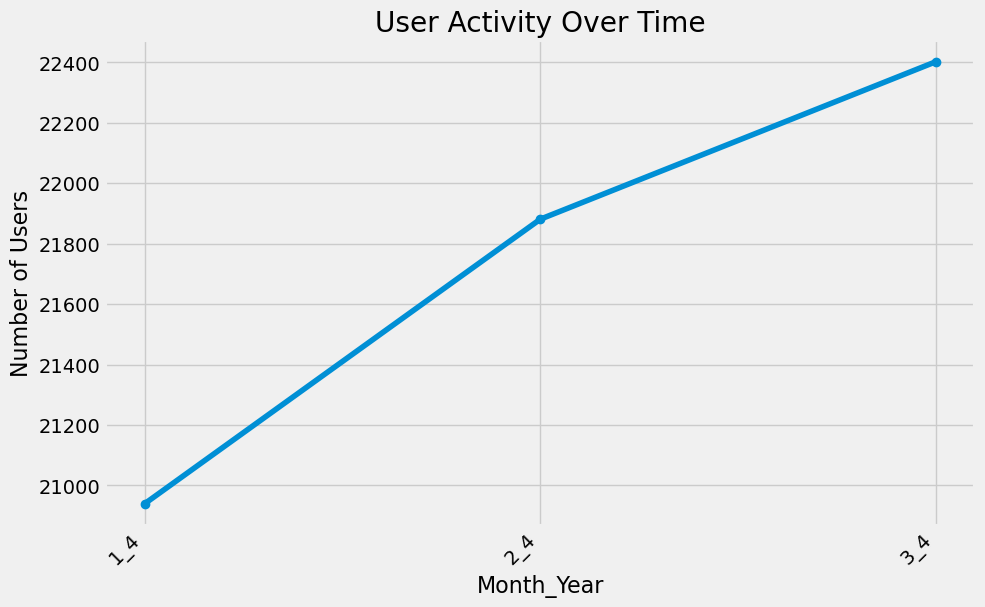

In [271]:
import matplotlib.pyplot as plt
test[['Year', 'Month']] = test['UserMonthYear'].str.split('_', expand = True).iloc[:, 2:]
monthly_user_count = test.groupby(['Year', 'Month'])['UserMonthYear'].count()

months = monthly_user_count.index
user_counts = monthly_user_count.values

month_labels = [f"{month}_{year}" for month, year in months]

plt.figure(figsize = (10, 6))
plt.plot(month_labels, user_counts, marker = 'o', linestyle = '-')
plt.xlabel('Month_Year')
plt.ylabel('Number of Users')
plt.title('User Activity Over Time')
plt.xticks(rotation = 45, ha = 'right')
plt.show()